In [1]:
import cantera as ct 
import numpy as np 
import pandas as pd
import time 
import matplotlib.pylab as plt 
import pdb 
from argparse import ArgumentParser
import os.path
import pyarrow.parquet as pq 
import pyarrow as pa
import multiprocessing
from pathos.multiprocessing import ProcessingPool
# Hello

In [50]:
class Particle(object):
    """Class for particle in BatchPaSR.
    """
    gas_template = None; 
    
    @classmethod
    def fromGas(cls, gas, particle_mass = 1.0):
        """Initialize particle object with thermochemical state.
        
        Parameters
        ----------
        gas : `cantera.Solution`
            Initial thermochemical state of particle
        
        particle_mass : `float`
            Particle mass
        
        Returns
        -------
        cls : `Particle`
            Instance of the Particle class
        """ 
        if Particle.gas_template == None:
            Particle.gas_template = ct.Solution(gas.name + ".xml")
        return cls(np.hstack([gas.T, gas.P, gas.X]), particle_mass, gas.name + ".xml")
    
    def __init__(self, state, particle_mass = 1.0, mech='gri30.xml'):
        """Initialize particle object with thermochemical state.

        Parameters
        ----------
        
        state : `numpy array or list`
            Initial thermochemical state of particle. Needs T, P, X. 
        
        gas : `cantera.Solution`
            Initial thermochemical state of particle
        
        particle_mass : `float`
            Particle mass
        
        Returns
        -------
        None

        """
        if Particle.gas_template == None:
            Particle.gas_template = ct.Solution(gas.name + ".xml")        
        self.mech = mech;
        self.P = state[1]
        Particle.gas_template.TPX = [state[0], state[1], state[2:]]
        self.column_names = ['age', 'T', 'MW', 'h'] + ["Y_" + sn for sn in Particle.gas_template.species_names] + ["X_" + sn for sn in Particle.gas_template.species_names]        
        self.mass = particle_mass
        self.age = 0
        self.state = np.hstack((Particle.gas_template.enthalpy_mass, Particle.gas_template.Y))
        self.timeHistory_list = [[self.age, Particle.gas_template.T, Particle.gas_template.mean_molecular_weight, Particle.gas_template.enthalpy_mass] + Particle.gas_template.Y.tolist() + Particle.gas_template.X.tolist()]
        self.timeHistory_array = None; 
    
    def __call__(self, comp=None):
        """Return or set composition.
        Parameters
        ----------
        comp : Optional[cantera.Solution]

        Returns
        -------
        comp : numpy.array
            Thermochemical composition of particle (enthalpy + mass fractions).

        """
        if comp is not None:
            if isinstance(comp, Particle):
                h = comp.gas.enthalpy_mass
                Y = comp.gas.Y
            elif isinstance(comp, np.ndarray):
                h = comp[0]
                Y = comp[1:]
            elif isinstance(comp, ct.Solution):
                h = comp.enthalpy_mass
                Y = comp.Y
            else:
                return NotImplemented
#             Particle.gas_template.HPY = h, self.P, Y
            self.state[0] = h
            self.state[1:] = Y
        else:
            return self.state

    def __add__(self, other):
        """Add values to state of particle without changing the state of either particle.

        Parameters
        ----------
        other : `Particle`, `numpy.array`, `int`, `float`
            Thermochemical state (enthalpy + mass fractions) to add to current state.

        Returns
        -------
        comp : numpy.array
            Thermochemical composition of particle (enthalpy + mass fractions).

        """
        if isinstance(other, Particle):
            return self.state + other.state
        elif isinstance(other, np.ndarray):
            return self.state + other
        elif isinstance(other, (int, float)):
            return self.state + other
        else:
            return NotImplemented

    def __radd__(self, other):
        """Add values to state of particle without changing the state of either particle.

        Parameters
        ----------
        other : `Particle`, `numpy.array`, `int`, `float`
            Thermochemical state (enthalpy + mass fractions) to add to current state.

        Returns
        -------
        comp : numpy.array
            Thermochemical composition of particle (enthalpy + mass fractions).

        """
        if isinstance(other, Particle):
            return self.state + other.state
        elif isinstance(other, np.ndarray):
            assert len(other) == len(self.state) , "Please ensure that input array has the same length as current particle state array ({0.d})".format()            
            return self.state + other
        elif isinstance(other, (int, float)):
            return self.state + other
        else:
            return NotImplemented

    def __sub__(self, other):
        """Subtract values from state of particle.

        Parameters
        ----------
        other : `Particle`, `numpy.array`, `int`, `float`
            Thermochemical state (enthalpy + mass fractions) to subtract from current state.

        Returns
        -------
        comp : numpy.array
            Thermochemical composition of particle (enthalpy + mass fractions).

        """
        if isinstance(other, Particle):
            return self.state - other.state
        elif isinstance(other, np.ndarray):
            return self.state - other
        elif isinstance(other, (int, float)):
            return self.state - other
        else:
            return NotImplemented

    def __rsub__(self, other):
        """Subtract state of particle from input state without changing the state of either particle.

        Parameters
        ----------
        other : `Particle`, `numpy.array`, `int`, `float`
            Thermochemical state from which to subract Particle state.

        Returns
        -------
        comp : numpy.array
            Thermochemical composition of particle (enthalpy + mass fractions).

        """
        if isinstance(other, Particle):
            return other.state - self.state
        elif isinstance(other, np.ndarray):
            return other - self.state
        elif isinstance(other, (int, float)):
            h = other - self.state[0]
            Y = other - self.state[1:]
            return np.hstack((h, Y))
        else:
            return NotImplemented

    def __mul__(self, other):
        """Multiply state of particle by value.

        Parameters
        ----------
        other : `int`, `float`
            Value to multiply `Particle` state by.

        Returns
        -------
        comp : numpy.array
            Thermochemical composition of particle (enthalpy + mass fractions).

        """
        if isinstance(other, (int, float)):
            return self.state * other
        else:
            return NotImplemented

    def __rmul__(self, other):
        """Multiply state of particle by value.

        Parameters
        ----------
        other : `int`, `float`
            Value to multiply `Particle` state by.

        Returns
        -------
        comp : numpy.array
            Thermochemical composition of particle (enthalpy + mass fractions).

        """
        if isinstance(other, (int, float)):
            return self.state * other
        else:
            return NotImplemented

    def __iadd__(self, other):
        """Add values to state of particle, modifying the state itself.

        Parameters
        ----------
        other : `Particle`, `numpy.array`, `int`, `float`
            Thermochemical state (enthalpy + mass fractions) to add to current state.

        Returns
        -------
        comp : numpy.array
            Thermochemical composition of particle (enthalpy + mass fractions).

        """
        if isinstance(other, Particle):
            h = self.state[0] + other.state[0]
            Y = self.state[1:] + other.state[1:]
        elif isinstance(other, np.ndarray):
            assert len(other) == len(self.state) , "Please ensure that input array has the same length as current particle state array ({0.d})".format()
            h = self.state[0] + other[0]
            Y = self.state[1:] + other[1:]
        elif isinstance(other, (int, float)):
            h = self.state[0] + other
            Y = self.state[1:] + other
        else:
            return NotImplemented
        self.state[0] = h
        self.state[1:] = Y
        return self

    def __isub__(self, other):
        """Subtract values from state of particle, modifying the particle itself.

        Parameters
        ----------
        other : `Particle`, `numpy.array`, `int`, `float`
            Thermochemical state (enthalpy + mass fractions) to subtract from current state.

        Returns
        -------
        comp : numpy.array
            Thermochemical composition of particle (enthalpy + mass fractions).

        """
        if isinstance(other, Particle):
            h = self.state[0] - other.state[0]
            Y = self.state[1:] - other.state[1:]
        elif isinstance(other, np.ndarray):
            assert len(other) == len(self.state) , "Please ensure that input array has the same length as current particle state array ({0.d})".format()
            h = self.state[0] - other[0]
            Y = self.state[1:] - other[1:]
        elif isinstance(other, (int, float)):
            h = self.state[0] - other
            Y = self.state[1:] - other
        else:
            return NotImplemented
        self.state[0] = h
        self.state[1:] = Y
        return self

    def __imul__(self, other):
        """Multiply state of particle by value, modifying the particle itself.

        Parameters
        ----------
        other : `int`, `float`
            Value to multiply `Particle` state by.

        Returns
        -------
        comp : numpy.array
            Thermochemical composition of particle (enthalpy + mass fractions).

        """
        if isinstance(other, (int, float)):
            self.state *= other
            return self
        else:
            return NotImplemented
        

    def react(self, dt):
        """Perform reaction timestep by advancing network.

        Parameters
        ----------
        dt : float
            Reaction timestep [seconds]

        Returns
        -------
        None

        """
        Particle.gas_template.HPY = [self.state[0], self.P, self.state[1:]]
        self.timeHistory_list.append([self.age, Particle.gas_template.T, Particle.gas_template.mean_molecular_weight, Particle.gas_template.enthalpy_mass] + Particle.gas_template.Y.tolist() + Particle.gas_template.X.tolist())        
        reac = ct.ConstPressureReactor(Particle.gas_template,
            volume= self.mass/Particle.gas_template.density)
        netw = ct.ReactorNet([reac])
        netw.advance(dt)
        self.age += dt
#         self.timeHistory_list = [[self.age, Particle.gas_template.T, Particle.gas_template.mean_molecular_weight, Particle.gas_template.enthalpy_mass] + Particle.gas_template.Y.tolist() + Particle.gas.X.tolist()]        
        self.timeHistory_list.append([self.age, Particle.gas_template.T, Particle.gas_template.mean_molecular_weight, Particle.gas_template.enthalpy_mass] + Particle.gas_template.Y.tolist() + Particle.gas_template.X.tolist())
        self.state = np.hstack((Particle.gas_template.enthalpy_mass, Particle.gas_template.Y))

    def get_timeHistory(self, dataFrame=False):
        """Obtain particle's history. 
        
        Parameters
        ----------
        None
        
        Returns
        -------
        timeHistory_array : `numpy.array` 
            The array containing particle property time traces 
        """
        self.timeHistory_array = np.vstack(self.timeHistory_list)
        if dataFrame == True:
            df = pd.DataFrame(columns = self.column_names, data = self.timeHistory_array)
            df.set_index(['age']); 
            return df
        
        return self.timeHistory_array

    def __getstate__(self):
        # how to get the state data out of a Particle instance
        state = self.__dict__.copy()
        return state

    def __setstate__(self, state):
        # rebuild a Particle instance from state
        self.__dict__.update(state)

In [65]:
class PaSBR(object):
    def __init__(self, particle_list, N_MAX=10, dt = 0.01e-3):
        """Initialize BatchPaSR from a list of Particles
        
        Parameters
        ----------
        particle_list : `List/numpy array of Particles`
            A python list/array of Particle objects
        
        Returns
        -------
        None 
        
        """ 
        
        self.column_names = ['age', 'mass', 'T', 'MW', 'h'] + ["Y_" + sn for sn in Particle.gas_template.species_names] + ["X_" + sn for sn in Particle.gas_template.species_names]        
        self.P = particle_list[0].P # NOTE: Assume all particles have same temp
        self.particle_list = particle_list
        self.N_MAX = N_MAX
        self.dt = dt
        self.ParticleFlowController = None
        self.time = 0
        self.mass = 0
        self.state = None
        self.N = len(self.particle_list)
        self.mean_gas = ct.Solution(Particle.gas_template.name + ".xml")
        self.mean_gas.name = "BatchPaSR Mean Gas"
        self.mean_gas.HPY = particle_list[0].state[0], self.P, particle_list[0].state[1:]
        self.updateState()
        self.timeHistory_list = [[self.time, self.mass, self.mean_gas.T, self.mean_gas.mean_molecular_weight, self.mean_gas.enthalpy_mass] + self.mean_gas.Y.tolist() + self.mean_gas.X.tolist()]        
        self.massList = [self.mass]

    def __call__(self):
        self.mean_gas()
        return self.state
    
    def updateState(self):
        """Update mass, number of particles, and BatchPaSR state vector
        
        Parameters
        ----------
        None
        
        Returns
        -------
        None
        """
        self.mass = sum([p.mass for p in self.particle_list]) # Note: can remove this if we're not updating particle_list if we don't usually update particle_list before we call this method
        self.N = len(self.particle_list)  
        self.state = sum([p.mass * p.state for p in self.particle_list])/self.mass # use p() or p.state?
        self.mean_gas.HPY = self.state[0], self.mean_gas.P, self.state[1:]
        assert all([round(particle.P) == round(self.P) for particle in self.particle_list]), "BatchPaSR does not support particles with different pressures (yet)"
        assert self.N <= self.N_MAX , "N > N_MAX; too many particles"
        
        
    def insert(self, particle):
        self.particle_list.append(particle); 
        self.updateState() # Is the cost of assigning N to a new value (in updateState()) higher than doing N += 1?
    
    @classmethod
    def reactHelper(cls, particle_dt):
        particle, dt = particle_dt
        particle.react(dt)
        return particle.__getstate__()
        
    def react(self, parallel=False):
        if parallel:
            pool = multiprocessing.Pool(processes=4)
            jobList = [(p, self.dt) for p in self.particle_list]
#             states = ProcessingPool().map(BatchPaSR.reactHelper, jobList)
            states = pool.map(BatchPaSR.reactHelper, jobList)
            pool.close()
            [self.particle_list[i].__setstate__(states[i]) for i in range(0, len(self.particle_list))]
        else:
            [p.react(self.dt) for p in self.particle_list]
        self.updateState()
        self.time += self.dt        
        self.timeHistory_list.append([self.time, self.mass, self.mean_gas.T, self.mean_gas.mean_molecular_weight, self.mean_gas.enthalpy_mass] + self.mean_gas.Y.tolist() + self.mean_gas.X.tolist())
    
#     def iem(cls, paticle_list)
    def _iem(self, particle_list, k):
        k_avg = k*self.state;
        for p in particle_list:
            p.state = p * (k + 1) - k_avg
 
    def mix(self, tau_mix):
        # Constant k:
        k = -self.dt/tau_mix # note: actually, k = -0.5*C_phi*omega*dt, but since C_phi is usually 2, i canceled it out.
        k_avg = k*self.state;
        [p(p * (k + 1) - k_avg) for p in self.particle_list]
        self.updateState()
        
    def get_timeHistory(self, dataFrame=True):
        """Obtain particle's history. 
        
        Parameters
        ----------
        None
        
        Returns
        -------
        timeHistory_array : `numpy.array` 
            The array containing particle property time traces 
        """
        self.timeHistory_array = np.vstack(self.timeHistory_list)
        if dataFrame == True:
            df = pd.DataFrame(columns = self.column_names, data = self.timeHistory_array)
            df.set_index(['age']); 
            return df
        
        return self.timeHistory_array        

In [4]:
milliseconds = 0.001 # seconds 

def runFlame(gas):
    # Simulation parameters
    width = 0.06  # m
    # Flame object
    f = ct.FreeFlame(gas, width=width)
    f.set_refine_criteria(ratio=2, slope=0.05, curve=0.05)
    f.transport_model = 'Multi'
    #     f.soret_enabled = True
    f.solve(loglevel=0, auto=True, refine_grid=True)
    # print('\nmixture-averaged flamespeed = {:7f} m/s\n'.format(f.u[0]))

    # Convert distance into time:
    Q_perc = 100 * f.heat_release_rate / max(f.heat_release_rate)
    maxIndex = np.arange(0, len(f.heat_release_rate))[f.heat_release_rate == max(f.heat_release_rate)][0]
    target_Q_perc = 75
    Q_diff = abs(Q_perc[0:maxIndex] - target_Q_perc)
    startingIndex = np.arange(0, len(Q_diff))[Q_diff == min(Q_diff)][0]
    startingIndex = np.arange(0, len(f.T))[f.T >= f.T[0] + 5][0]
    #     startingIndex = np.arange(0, len(f.heat_release_rate))[f.heat_release_rate == max(f.heat_release_rate)][0]
    u_avg = np.array(f.u[startingIndex:] + f.u[startingIndex - 1:-1]) * 0.5
    dx = np.array(f.grid[startingIndex:] - f.grid[startingIndex - 1:-1])
    dt = dx / u_avg

    pre_time = [-999] * (startingIndex-1)  # need to add some padding to the time array to account for dist = 0.0
    pre_time.extend([0])
    time = np.hstack(
        (np.array(pre_time), np.cumsum(dt)))  # numerically integrate (read: sum) dt to get array of times for each x location

    return f, time

def mix(streams, mdots, mech="gri30.xml", P=25*101325):
    # Create mixer gas: 
    mixerGas = ct.Solution(mech) 
    mixerGas.TPX = [300, P, 'H2:1']
    
    # Create reactor with CHEMISTRY DISABLED: 
    mixer = ct.ConstPressureReactor(mixerGas) 
    mixer.chemistry_enabled = False # distable chemistry 
    
    # For each stream (and given mass flow rate), connect mass flow controller to mixer: 
    mfcs = [ct.MassFlowController(ct.Reservoir(streams[i]), mixer, mdot=mdots[i]) for i in range(0,len(streams))]
    
    exhaust = ct.Reservoir(mixerGas) 
    exhaust_mfc = ct.MassFlowController(mixer, exhaust, mdot=sum(mdots)) 
    
    rn = ct.ReactorNet([mixer]) 
    rn.advance_to_steady_state() 
    return mixer.thermo
    
def premix(phi=0.4, fuel={'CH4':1}, ox={'N2':0.79, 'O2':0.21}, mech='gri30.xml', P=25*101325, T_fuel=300, T_ox=650, M_total=1):
    
    air = ct.Solution(mech)
    air.TPX = [T_ox, P, ox]
    fuelGas = ct.Solution(mech)
    fuelGas.TPX = T_fuel, P, fuel
    
    # Temporary ThermoPhase object to get mass flow rates:
    temp = ct.Solution('gri30.xml')
    temp.set_equivalence_ratio(phi, fuel, ox)
    mdot_fuel = M_total * sum(temp[fuel.keys()].Y)
    mdot_ox = M_total * sum(temp[ox.keys()].Y)

    # Output mixer gas: 
    return mix([fuelGas, air], [mdot_fuel, mdot_ox], P=P)  

def getStateAtTime(flame, tList, tRequired, mech='gri30.xml'):
    '''A function that gets the state at a desired point in time of a flame simulation performed using runFlame. 
        Takes in a flame object, its associated time series, and the desired point in time.
        Returns a new Cantera gas object with the desired state, and the corresponding index in the flame at which the point was found. 

        Example usage: gas, t_ind = getStateAtTime(flame, time, t_req)'''
    mainBurnerDF = flame
    columnNames = mainBurnerDF.columns.values
    moleFracs = mainBurnerDF.columns[mainBurnerDF.columns.str.contains('X_')]
    assert (tRequired > 0)
    newGas = ct.Solution(mech)

    if (tRequired >= max(tList)):
        tau_vit = tRequired - max(tList)
        newGas.TPX = flame['T'].iloc[-1], flame['P'].iloc[-1], flame[moleFracs].iloc[-1]
        tau_vit_start = tList[-1]
    else:
        dt_list = abs(tList - tRequired)
        # Find index at which required time is closest to an entry in tList:     
        minIndex = next(ind for ind, val in enumerate(dt_list) if abs(val - min(dt_list)) < 1e-6)
        flameTime_closestTreq = tList[minIndex] 
        if ((flameTime_closestTreq - tRequired) > 1e-5):
            newGas.TPX = flame['T'].iloc[minIndex-1], flame['P'].iloc[minIndex-1], flame[moleFracs].iloc[minIndex-1]
            tau_vit = tRequired - tList[minIndex - 1]
            tau_vit_start = tList[minIndex - 1]
            assert(tau_vit > 0)# if the closest flameTime is larger than tRequired, the second closest should be less than, otherwise /that/ would be the closest...?
        elif ((tRequired - flameTime_closestTreq) > 1e-5): # if closest time is more than 1e-5 s less than tReq
            newGas.TPX = flame['T'].iloc[minIndex], flame['P'].iloc[minIndex], flame[moleFracs].iloc[minIndex] 
            tau_vit = tRequired - tList[minIndex] 
            tau_vit_start = tList[minIndex]
        else:
            newGas.TPX = flame['T'].iloc[minIndex], flame['P'].iloc[minIndex], flame[moleFracs].iloc[minIndex]
            tau_vit = 0
    if tau_vit > 0:
        # print("Flame too short using ConstPressureReactor to extend by", tau_vit / 1e-3, "milliseconds.")
        # print("Vitiator start time:", tau_vit_start/1e-3, "milliseconds.") 
        
        vitiator = ct.ConstPressureReactor(newGas)
        vitRN = ct.ReactorNet([vitiator])
        dt = 0.001 * 1e-3
        vit_tList = np.arange(0, tau_vit, dt)
        vitArray = np.array([None] * len(vit_tList) * len(columnNames)).reshape(len(vit_tList), len(columnNames))
        # performance note: we don't need to do this. we can simply just advance to the desired tau_main
        for i in range(0, len(vit_tList)):
            MWi = vitiator.thermo.mean_molecular_weight
            vitArray[i, :] = np.hstack([vitiator.thermo.T, vitiator.thermo.P, 0, MWi, vitiator.thermo.Y, vitiator.thermo.X])
            vitRN.advance(vit_tList[i])
        vit_tList += tau_vit_start             
        vitDF = pd.DataFrame(data=vitArray, index=vit_tList, columns=columnNames)
        '''Append tList with additional times DO NOT REASSIGN! We are using the Python pass by object feature'''
        #         tList = np.concatenate((tList, vit_tList + tau_vit_start))
        # print("Vitiator end time:", vit_tList[-1]/1e-3, "milliseconds") 
        vitiator.syncState()
        '''Call syncState so that newGas has the right state for use in later functions.'''
        minIndex = -1  # last index in time list 
        mainBurnerDF = mainBurnerDF[np.array(mainBurnerDF.index > 0) & np.array(mainBurnerDF.index <= tRequired)]
        # print("Initial mainBurnerDF length:", len(mainBurnerDF.index.values))
        mainBurnerDF = pd.concat([mainBurnerDF, vitDF])        
        # print("New mainBurnerDF length:", len(mainBurnerDF.index.values))
    mainBurnerDF['NOppmvd'] = correctNOx(mainBurnerDF['X_NO'], mainBurnerDF['X_H2O'], mainBurnerDF['X_O2'])
    mainBurnerDF['COppmvd'] = correctNOx(mainBurnerDF['X_CO'], mainBurnerDF['X_H2O'], mainBurnerDF['X_O2'])    
    return newGas, minIndex, mainBurnerDF

def correctNOx(X_i, X_H2O, X_O2):
    dry_i = X_i/(1 - X_H2O)
    dry_O2 = X_O2/(1 - X_H2O)
    corrected = dry_i*(20.9 - 15)/(20.9 - dry_O2*100)
    corrected_ppm = corrected*1e6
    return corrected_ppm     

def runMainBurner(phi_main, tau_main, T_fuel=300, T_ox=650, P=25*101325, mech="gri30.xml"): 
    flameGas = premix(phi_main, P=P, mech=mech, T_fuel=T_fuel, T_ox=T_ox) 
    # filename = '{0}_{1}-{2}_{3}-{4}_{5}'.format('phi_main', phi_main, 'P', P, )
    filename = '{0}_{1:.3f}.pickle'.format('phi_main', phi_main);
    if os.path.isfile(filename):
        # with open(filename, 'rb') as flameFile:
            table = pq.read_table(filename, nthreads=5)
            mainBurnerDF = table.to_pandas()
            # mainBurnerDF = pickle.load(flameFile)
            flameTime = mainBurnerDF.index.values;
    else:
        flame, flameTime = runFlame(flameGas)
        columnNames = ['T', 'n', 'MW'] + ["Y_" + sn for sn in flameGas.species_names] + ["X_" + sn for sn in
                                                                                    flameGas.species_names]
        flameData = np.concatenate(
            [np.array([flame.T]), np.array([[0] * len(flame.T)]), np.array([[0] * len(flame.T)]), flame.Y, flame.X], axis=0)
        mainBurnerDF = pd.DataFrame(data=flameData.transpose(), index=flameTime, columns=columnNames)
        mainBurnerDF.index.name = 'Time'
        mainBurnerDF['P'] = flame.P;
        table = pa.Table.from_pandas(mainBurnerDF);
        pq.write_table(table, filename);
    vitiatedProd, flameCutoffIndex, mainBurnerDF = getStateAtTime(mainBurnerDF, flameTime, tau_main)
    vitReactor = ct.ConstPressureReactor(vitiatedProd)
    return vitReactor, mainBurnerDF

def solvePhi_airSplit(phiGlobal, phiMain, mdotTotal=1000, airSplit=1):
    # fs = 
    fs = 0.058387057492574147;
    mfm = airSplit*fs*mdotTotal*(1+fs*phiGlobal)**(-1)*phiMain
    mam = airSplit*mdotTotal*(1+fs*phiGlobal)**(-1)
    mfs = (-1)*(1+fs*phiGlobal)**(-1)*((-1)*fs*mdotTotal*phiGlobal+airSplit*fs*mdotTotal*phiMain)
    mas = (-1)*((-1)+airSplit)*mdotTotal*(1+fs*phiGlobal)**(-1)
    return mfm, mam, mfs, mas


In [78]:
[mfm, mam, mfs, mas] = solvePhi_airSplit(0.638, 0.4, 100, 1)
[vit_reactor, main_burner_DF] = runMainBurner(0.4, 19*milliseconds)

vit_particle = Particle.fromGas(vit_reactor.thermo, particle_mass = (mfm + mam));
# g1 = ct.Solution('gri30.xml'); 

secondary_gas = ct.Solution('gri30.xml'); 
secondary_gas.TPX = 300, 25*ct.one_atm, {'CH4':1}
secondary_part = Particle.fromGas(secondary_gas, particle_mass=mfs+mas)

In [79]:
bp = PaSBR(particle_list=[vit_particle, secondary_part], dt=0.001*milliseconds)

In [80]:
t = np.arange(0, 5*milliseconds, bp.dt)
for i in range(0,t.size):
    bp.react();
    bp.mix(tau_mix=0.1*milliseconds)
    bp.entrain()
#     bp();

In [84]:
df1 = bp.particle_list[0].get_timeHistory(dataFrame=True)
df2 = bp.particle_list[1].get_timeHistory(dataFrame=True)

In [72]:
bp.get_timeHistory()

,age,mass,T,MW,h,Y_H2,Y_H,Y_O,Y_O2,Y_OH,...,X_HCNO,X_HOCN,X_HNCO,X_NCO,X_N2,X_AR,X_C3H7,X_C3H8,X_CH2CHO,X_CH3CHO
0,0.000000,100.0,1501.049940,28.039953,184109.656444,7.923742e-08,6.064468e-10,5.237716e-07,0.134891,3.077076e-05,...,4.153190e-10,5.064236e-11,2.365105e-10,8.575153e-13,0.740276,0.000000e+00,1.007519e-18,1.786689e-16,1.832141e-15,4.094127e-16
1,0.000001,100.0,1501.053621,28.039960,184109.656084,7.851388e-08,6.039436e-10,5.231006e-07,0.134890,3.076081e-05,...,4.153104e-10,5.065000e-11,2.363200e-10,8.564313e-13,0.740276,0.000000e+00,3.783836e-19,1.534551e-16,1.757902e-15,3.798110e-16
2,0.000002,100.0,1501.057288,28.039967,184109.657284,7.781397e-08,6.016131e-10,5.224927e-07,0.134890,3.075063e-05,...,4.153018e-10,5.065763e-11,2.361297e-10,8.554144e-13,0.740276,0.000000e+00,3.248851e-19,1.318055e-16,1.687971e-15,3.523682e-16
3,0.000003,100.0,1501.185038,28.039997,184109.659341,1.137832e-07,3.565090e-09,4.675385e-07,0.134880,6.437764e-06,...,4.156527e-10,5.063018e-11,2.379491e-10,4.144847e-13,0.740277,0.000000e+00,1.953839e-13,2.069681e-10,8.152100e-12,1.100020e-10
4,0.000004,100.0,1501.265553,28.040025,184109.658594,1.612601e-07,3.441664e-09,3.391295e-07,0.134868,2.517267e-06,...,4.157945e-10,5.059481e-11,2.389304e-10,1.535881e-13,0.740278,0.000000e+00,4.988441e-13,9.097878e-10,1.345754e-11,3.323742e-10
5,0.000005,100.0,1501.336251,28.040045,184109.658483,2.135589e-07,3.571275e-09,2.791410e-07,0.134856,1.843576e-06,...,4.158644e-10,5.055835e-11,2.394839e-10,8.242411e-14,0.740278,0.000000e+00,8.482387e-13,1.809446e-09,1.962855e-11,5.455026e-10
6,0.000006,100.0,1501.407774,28.040060,184109.659405,2.726642e-07,3.724012e-09,2.439925e-07,0.134844,1.527552e-06,...,4.159124e-10,5.052030e-11,2.399245e-10,6.147770e-14,0.740279,0.000000e+00,1.247571e-12,2.862602e-09,2.587790e-11,7.531577e-10
7,0.000007,100.0,1501.481778,28.040072,184109.659432,3.390536e-07,3.881390e-09,2.212091e-07,0.134831,1.340758e-06,...,4.159483e-10,5.048067e-11,2.403226e-10,5.318015e-14,0.740279,0.000000e+00,1.711243e-12,4.078796e-09,3.247090e-11,9.616797e-10
8,0.000008,100.0,1501.558977,28.040083,184109.659737,4.128704e-07,4.040995e-09,2.055032e-07,0.134818,1.219424e-06,...,4.159762e-10,5.043949e-11,2.407010e-10,4.891852e-14,0.740279,0.000000e+00,2.252821e-12,5.471188e-09,3.962030e-11,1.175254e-09
9,0.000009,100.0,1501.639731,28.040093,184109.659779,4.941348e-07,4.202708e-09,1.942368e-07,0.134804,1.136047e-06,...,4.159984e-10,5.039676e-11,2.410699e-10,4.638958e-14,0.740280,0.000000e+00,2.886454e-12,7.052354e-09,4.745533e-11,1.396761e-09


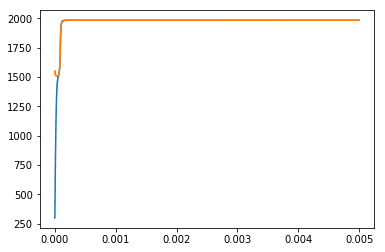

In [76]:
plt.plot(df1['age'], df2['T'])
plt.plot(df1['age'], df1['T'])

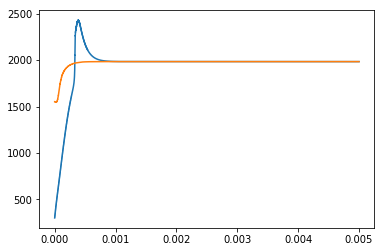

In [85]:
plt.plot(df1['age'], df2['T'])
plt.plot(df1['age'], df1['T'])

In [87]:
a = np.array([4,1,4,7,2,0,2,2,8,1,7,6,5,9,7,2])

In [88]:
b = np.array(range(0,len(a)))

In [94]:
c = a + 5757

In [95]:
c

array([5761, 5758, 5761, 5764, 5759, 5757, 5759, 5759, 5765, 5758, 5764,
       5763, 5762, 5766, 5764, 5759])

In [ ]:
0124998237

security = 187